[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLO11 Object Detection on a Custom Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

YOLO11 builds on the advancements introduced in YOLOv9 and YOLOv10 earlier this year, incorporating improved architectural designs, enhanced feature extraction techniques, and optimized training methods.

YOLO11m achieves a higher mean mAP score on the COCO dataset while using 22% fewer parameters than YOLOv8m, making it computationally lighter without sacrificing performance.

YOLOv11 is available in 5 different sizes, ranging from `2.6M` to `56.9M` parameters, and capable of achieving from `39.5` to `54.7` mAP on the COCO dataset.

## Setup

### Configure API keys

To fine-tune YOLO11, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
# Not working on macOS with Apple Silicon (arm64); no cuda support

# !nvidia-smi

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os

HOME = os.getcwd()
print(HOME)

/Users/tillmeineke/ML/ML_Zoomcamp2024_hw/helloListenDog/notebooks


## Install YOLO11 via Ultralytics

In [ ]:
# ultrlytics and super vision added to environment.yaml
# %pip install -q "ultralytics<=8.3.40" supervision roboflow

import ultralytics

ultralytics.checks()

Ultralytics 8.3.61 🚀 Python-3.11.11 torch-2.5.1 CPU (Apple M1)
Setup complete ✅ (8 CPUs, 16.0 GB RAM, 411.9/460.4 GB disk)


In [43]:
print(ultralytics.settings)

JSONDict("/Users/tillmeineke/Library/Application Support/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/Users/tillmeineke/ML/ML_Zoomcamp2024_hw/helloListenDog/data/split_yolo",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "0f7fcc74715e91668d2afc4bf9af2ef2d43c8fa1a9b6ae4113f192bc54814f46",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": true,
  "wandb": false,
  "vscode_msg": true
}


## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [77]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='../data/raw/stanford/american_staffordshire_terrier/n02093428_10164.jpg' save=True

Ultralytics 8.3.61 🚀 Python-3.11.11 torch-2.5.1 CPU (Apple M1)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients

image 1/1 /Users/tillmeineke/ML/ML_Zoomcamp2024_hw/helloListenDog/notebooks/../data/raw/stanford/american_staffordshire_terrier/n02093428_10164.jpg: 448x640 1 dog, 73.9ms
Speed: 2.7ms preprocess, 73.9ms inference, 16.3ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/predict/` or sth like. Let's display it.

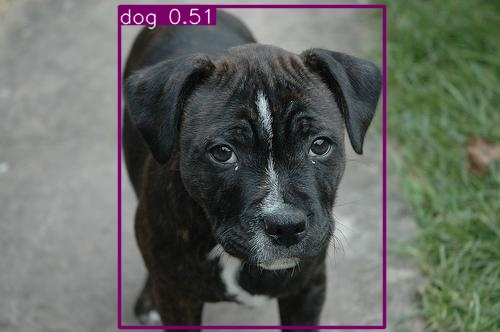

In [79]:
from IPython.display import Image as IPyImage

IPyImage(filename=f"{HOME}/runs/detect/predict2/n02093428_10164.jpg", width=600)

### SDK

**NOTE:** YOLO's Python interface allows for seamless integration into your Python projects, making it easy to load, run, and process the model's output.

In [ ]:
from ultralytics import YOLO
from PIL import Image
# import requests

model = YOLO("yolo11n.pt")
# image = Image.open(
#     requests.get(
#         "https://media.roboflow.com/notebooks/examples/dog.jpeg", stream=True
#     ).raw
# )
image = Image.open("../data/raw/stanford/american_staffordshire_terrier/n02093428_10164.jpg")
result = model.predict(image, conf=0.25)[0]


0: 448x640 1 dog, 54.6ms
Speed: 4.0ms preprocess, 54.6ms inference, 5.4ms postprocess per image at shape (1, 3, 448, 640)


**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [2]:
result.boxes.xyxy

tensor([[119.2781,   6.1632, 384.0934, 327.8011]])

In [3]:
result.boxes.conf

tensor([0.5089])

In [4]:
result.boxes.cls

tensor([16.])

**NOTE:** YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [5]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

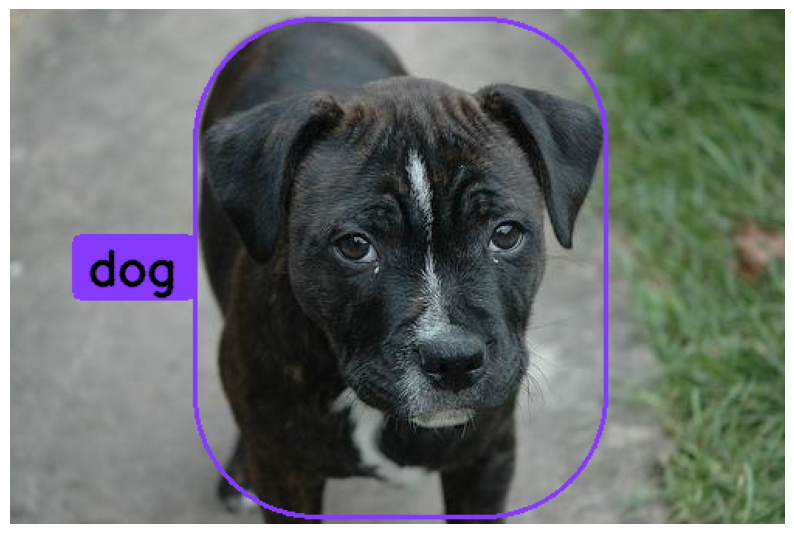

In [28]:
box_annotator = sv.RoundBoxAnnotator()
label_annotator = sv.LabelAnnotator(
    text_color=sv.Color.BLACK,
    text_scale=1,
    text_thickness=2,
    text_position=sv.Position.CENTER_LEFT,
    border_radius=5,
    smart_position=True,
)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [14]:
# !mkdir {HOME}/datasets
# %cd {HOME}/datasets

# from google.colab import userdata
# from roboflow import Roboflow

# ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
# rf = Roboflow(api_key=ROBOFLOW_API_KEY)

# # workspace = rf.workspace("liangdianzhong")
# # project = workspace.project("-qvdww")
# # version = project.version(3)
# # dataset = version.download("yolov11")
# project = rf.workspace("mlzoomcamp2024").project("hellolistendog_v1_dog_detection")
# version = project.version(1)
# dataset = version.download("yolov11")

## Load coco json dataset with supervision

In [15]:
HOME

'/Users/tillmeineke/ML/ML_Zoomcamp2024_hw/helloListenDog/notebooks'

In [23]:
import supervision as sv

In [61]:
dataset = sv.DetectionDataset.from_coco(
    images_directory_path="../data/renamed_dub_removed",
    annotations_path="../combined_coco.json",
)

In [62]:
dataset.image_paths[:5]

['../data/renamed_dub_removed/dogue_de_bordeaux_0040.jpg',
 '../data/renamed_dub_removed/staffordshire_bullterrier_0052.jpg',
 '../data/renamed_dub_removed/dogo_argentino_0020.jpg',
 '../data/renamed_dub_removed/cau_ovcharka_0076.jpg',
 '../data/renamed_dub_removed/cau_ovcharka_0133.jpg']

In [63]:
dataset.classes

['dogue_de_bordeaux',
 'staffordshire_bullterrier',
 'dogo_argentino',
 'other_dog_breed',
 'cau_ovcharka',
 'person',
 'human_face',
 'am_pit_bull_terrier',
 'fila_brasileiro',
 'bull_terrier',
 'kangal',
 'neapolitan_mastiff',
 'rottweiler',
 'bull_mastiff',
 'mastin_espanol',
 'tosa_inu',
 'am_staffordshire_terrier',
 'mastiff']

In [ ]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_images = []

for i in range(9):
    _, image, annotations = dataset[i]
    
    labels = [dataset.classes[class_id] for class_id in annotations.class_id]
    
    annotated_image = image.copy()
    annotated_image = box_annotator.annotate(annotated_image, annotations)
    annotated_image = label_annotator.annotate(annotated_image, annotations, labels,)
    annotated_images.append(annotated_image)

grid = sv.create_tiles(
    annotated_images,
    grid_size=(3,3),
    single_tile_size=(400, 400),
    tile_padding_color=sv.Color.WHITE,
    tile_margin_color=sv.Color.WHITE,
)

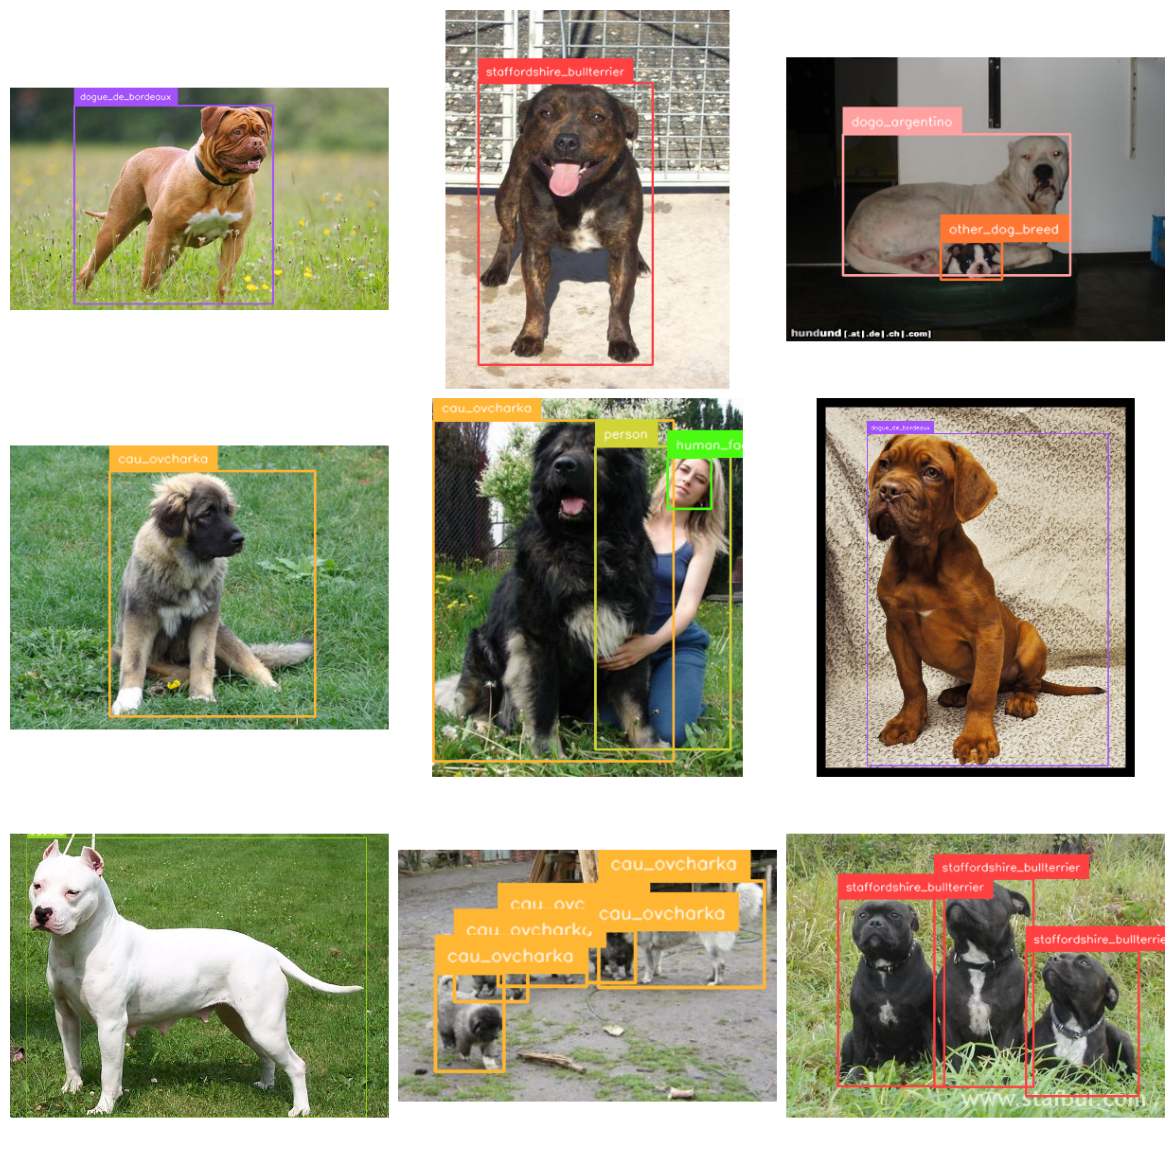

In [76]:
sv.plot_image(grid, size=(15, 15))

## Custom Training

In [59]:
import os
os.environ.get("MLFLOW_TRACKING_URI")

'runs/mlflow'

In [60]:
os.environ.get("MLFLOW_EXPERIMENT_NAME")

In [61]:
os.environ.get("MLFLOW_RUN")

In [64]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n.yaml")  # build a new model from YAML
model = YOLO("yolo11n.pt")  # load a pretrained model (recommended for training)
model = YOLO("yolo11n.yaml").load("yolo11n.pt")  # build from YAML and transfer weights

# Train the model
# !yolo settings mlflow=False
results = model.train(
    data="../data/split_yolo/dataset.yaml",
    epochs=10,
    imgsz=640,
    device="mps",
    #project="mlzoomcamp2024",
)


Transferred 499/499 items from pretrained weights
Ultralytics 8.3.61 🚀 Python-3.11.11 torch-2.5.1 MPS (Apple M1)
engine/trainer: task=detect, mode=train, model=yolo11n.yaml, data=../data/split_yolo/dataset.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=mps, workers=8, project=None, name=train, exist_ok=False, pretrained=yolo11n.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, s

train: Scanning /Users/tillmeineke/ML/ML_Zoomcamp2024_hw/helloListenDog/data/split_yolo/train/labels.cache... 1078 images, 0 backgrounds, 83 corrupt: 100%|██████████| 1079/1079 [00:00<?, ?it/s]

train: WARNING ⚠️ /Users/tillmeineke/ML/ML_Zoomcamp2024_hw/helloListenDog/data/split_yolo/train/images/american_pit_bull_terrier_0051.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0015]
train: WARNING ⚠️ /Users/tillmeineke/ML/ML_Zoomcamp2024_hw/helloListenDog/data/split_yolo/train/images/american_staffordshire_terrier_0026.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0003]
train: WARNING ⚠️ /Users/tillmeineke/ML/ML_Zoomcamp2024_hw/helloListenDog/data/split_yolo/train/images/american_staffordshire_terrier_0033.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0024]
train: WARNING ⚠️ /Users/tillmeineke/ML/ML_Zoomcamp2024_hw/helloListenDog/data/split_yolo/train/images/american_staffordshire_terrier_0034.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0014]
train: WARNING ⚠️ /Users/tillmeineke/ML/ML_Zoomcamp2024_hw/helloListenDog/dat


val: Scanning /Users/tillmeineke/ML/ML_Zoomcamp2024_hw/helloListenDog/data/split_yolo/valid/labels.cache... 393 images, 0 backgrounds, 21 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]

val: WARNING ⚠️ /Users/tillmeineke/ML/ML_Zoomcamp2024_hw/helloListenDog/data/split_yolo/valid/images/american_pit_bull_terrier_0054.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0005]
val: WARNING ⚠️ /Users/tillmeineke/ML/ML_Zoomcamp2024_hw/helloListenDog/data/split_yolo/valid/images/american_pit_bull_terrier_0093.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0006]
val: WARNING ⚠️ /Users/tillmeineke/ML/ML_Zoomcamp2024_hw/helloListenDog/data/split_yolo/valid/images/american_staffordshire_terrier_0120.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.002]
val: WARNING ⚠️ /Users/tillmeineke/ML/ML_Zoomcamp2024_hw/helloListenDog/data/split_yolo/valid/images/bull_mastiff_0048.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0002]
val: WARNING ⚠️ /Users/tillmeineke/ML/ML_Zoomcamp2024_hw/helloListenDog/data/split_yolo/valid/images/bull_ma

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000455, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)


Exception: 'runs/mlflow' does not exist.

## Custom Training

In [22]:
%cd {HOME}

# !yolo task=detect mode=train model=yolo11s.pt data="/Users/tillmeineke/ML/ML_Zoomcamp2024_hw/helloListenDog/data/split_yolo/dataset.yaml" epochs=10 imgsz=640 plots=True

/Users/tillmeineke/ML/ML_Zoomcamp2024_hw/helloListenDog/notebooks
Ultralytics 8.3.61 🚀 Python-3.11.11 torch-2.5.1 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/Users/tillmeineke/ML/ML_Zoomcamp2024_hw/helloListenDog/data/split_yolo/dataset.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [ ]:
# Load a model
model = YOLO("yolo11n.pt")  # load a pretrained model (recommended for training)

# Train the model on mps (metal plugin)
results = model.train(data="coco8.yaml", epochs=100, imgsz=640, device="mps")


In [25]:
!ls {HOME}/runs/detect/train/

args.yaml					    PR_curve.png	   val_batch0_pred.jpg
confusion_matrix_normalized.png			    R_curve.png		   val_batch1_labels.jpg
confusion_matrix.png				    results.csv		   val_batch1_pred.jpg
events.out.tfevents.1734996025.ef364868f20d.3860.0  results.png		   val_batch2_labels.jpg
F1_curve.png					    train_batch0.jpg	   val_batch2_pred.jpg
labels_correlogram.jpg				    train_batch1.jpg	   weights
labels.jpg					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


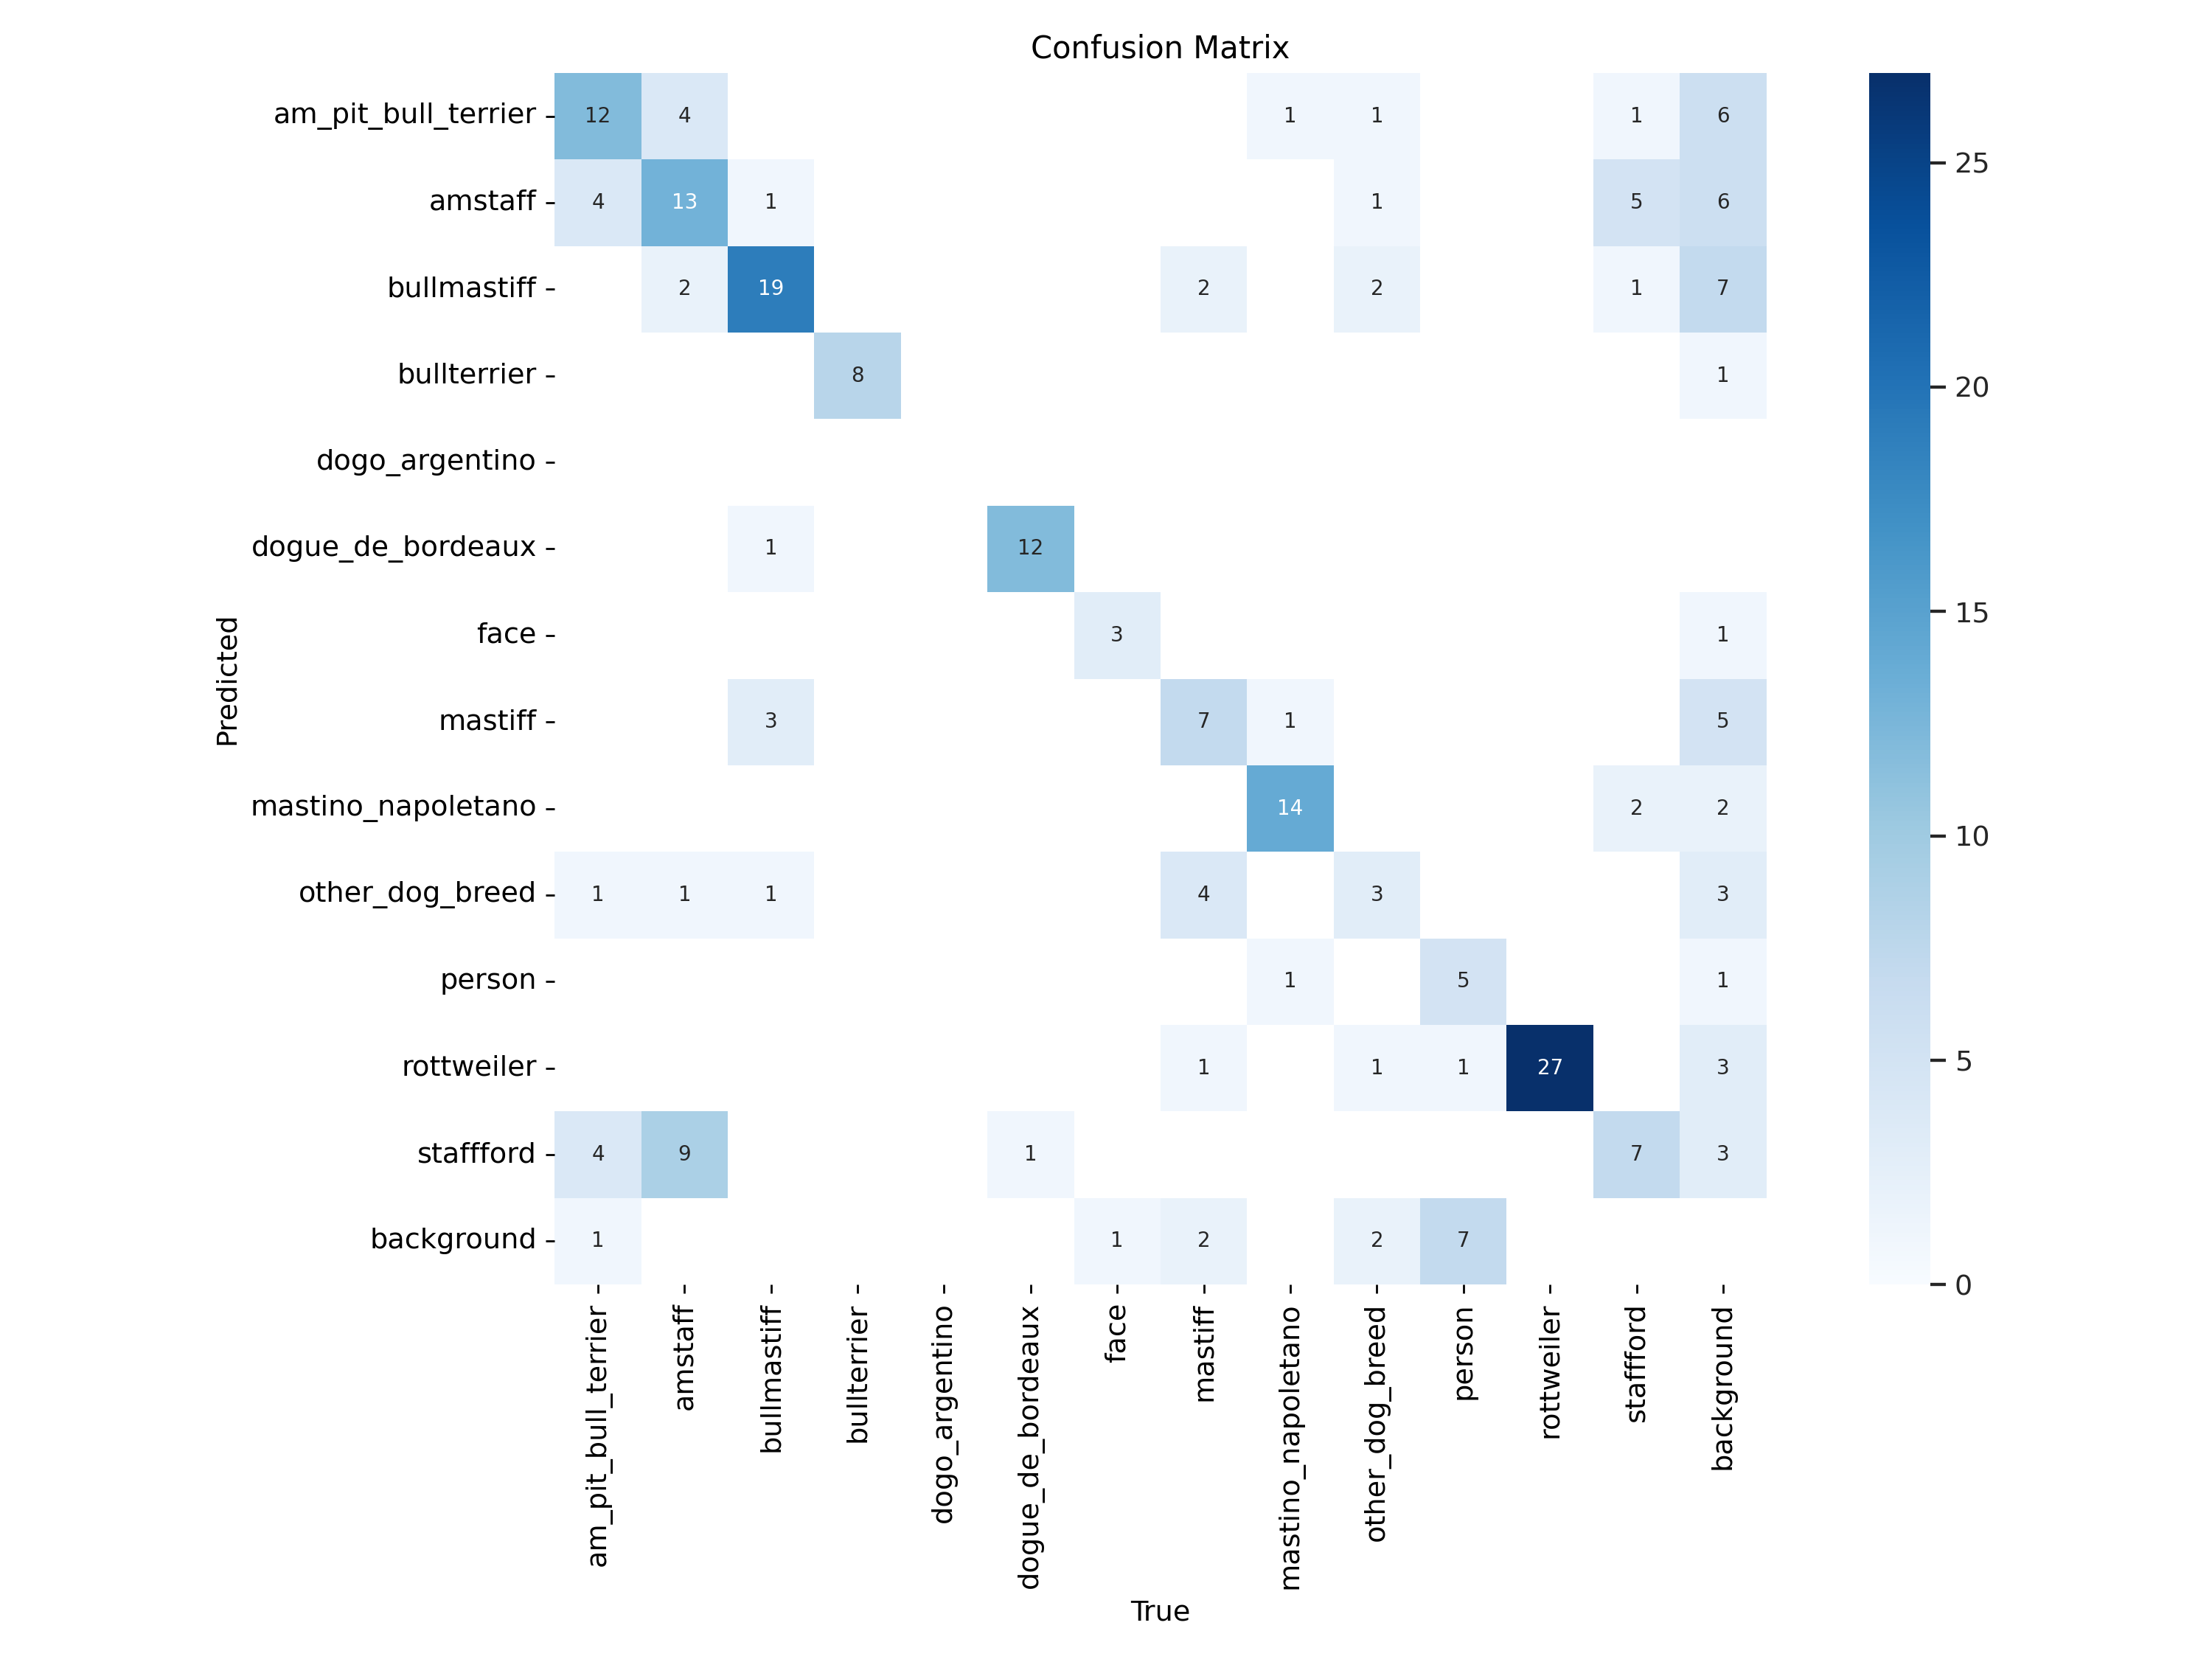

In [26]:
from IPython.display import Image as IPyImage

IPyImage(filename=f"{HOME}/runs/detect/train/confusion_matrix.png", width=600)

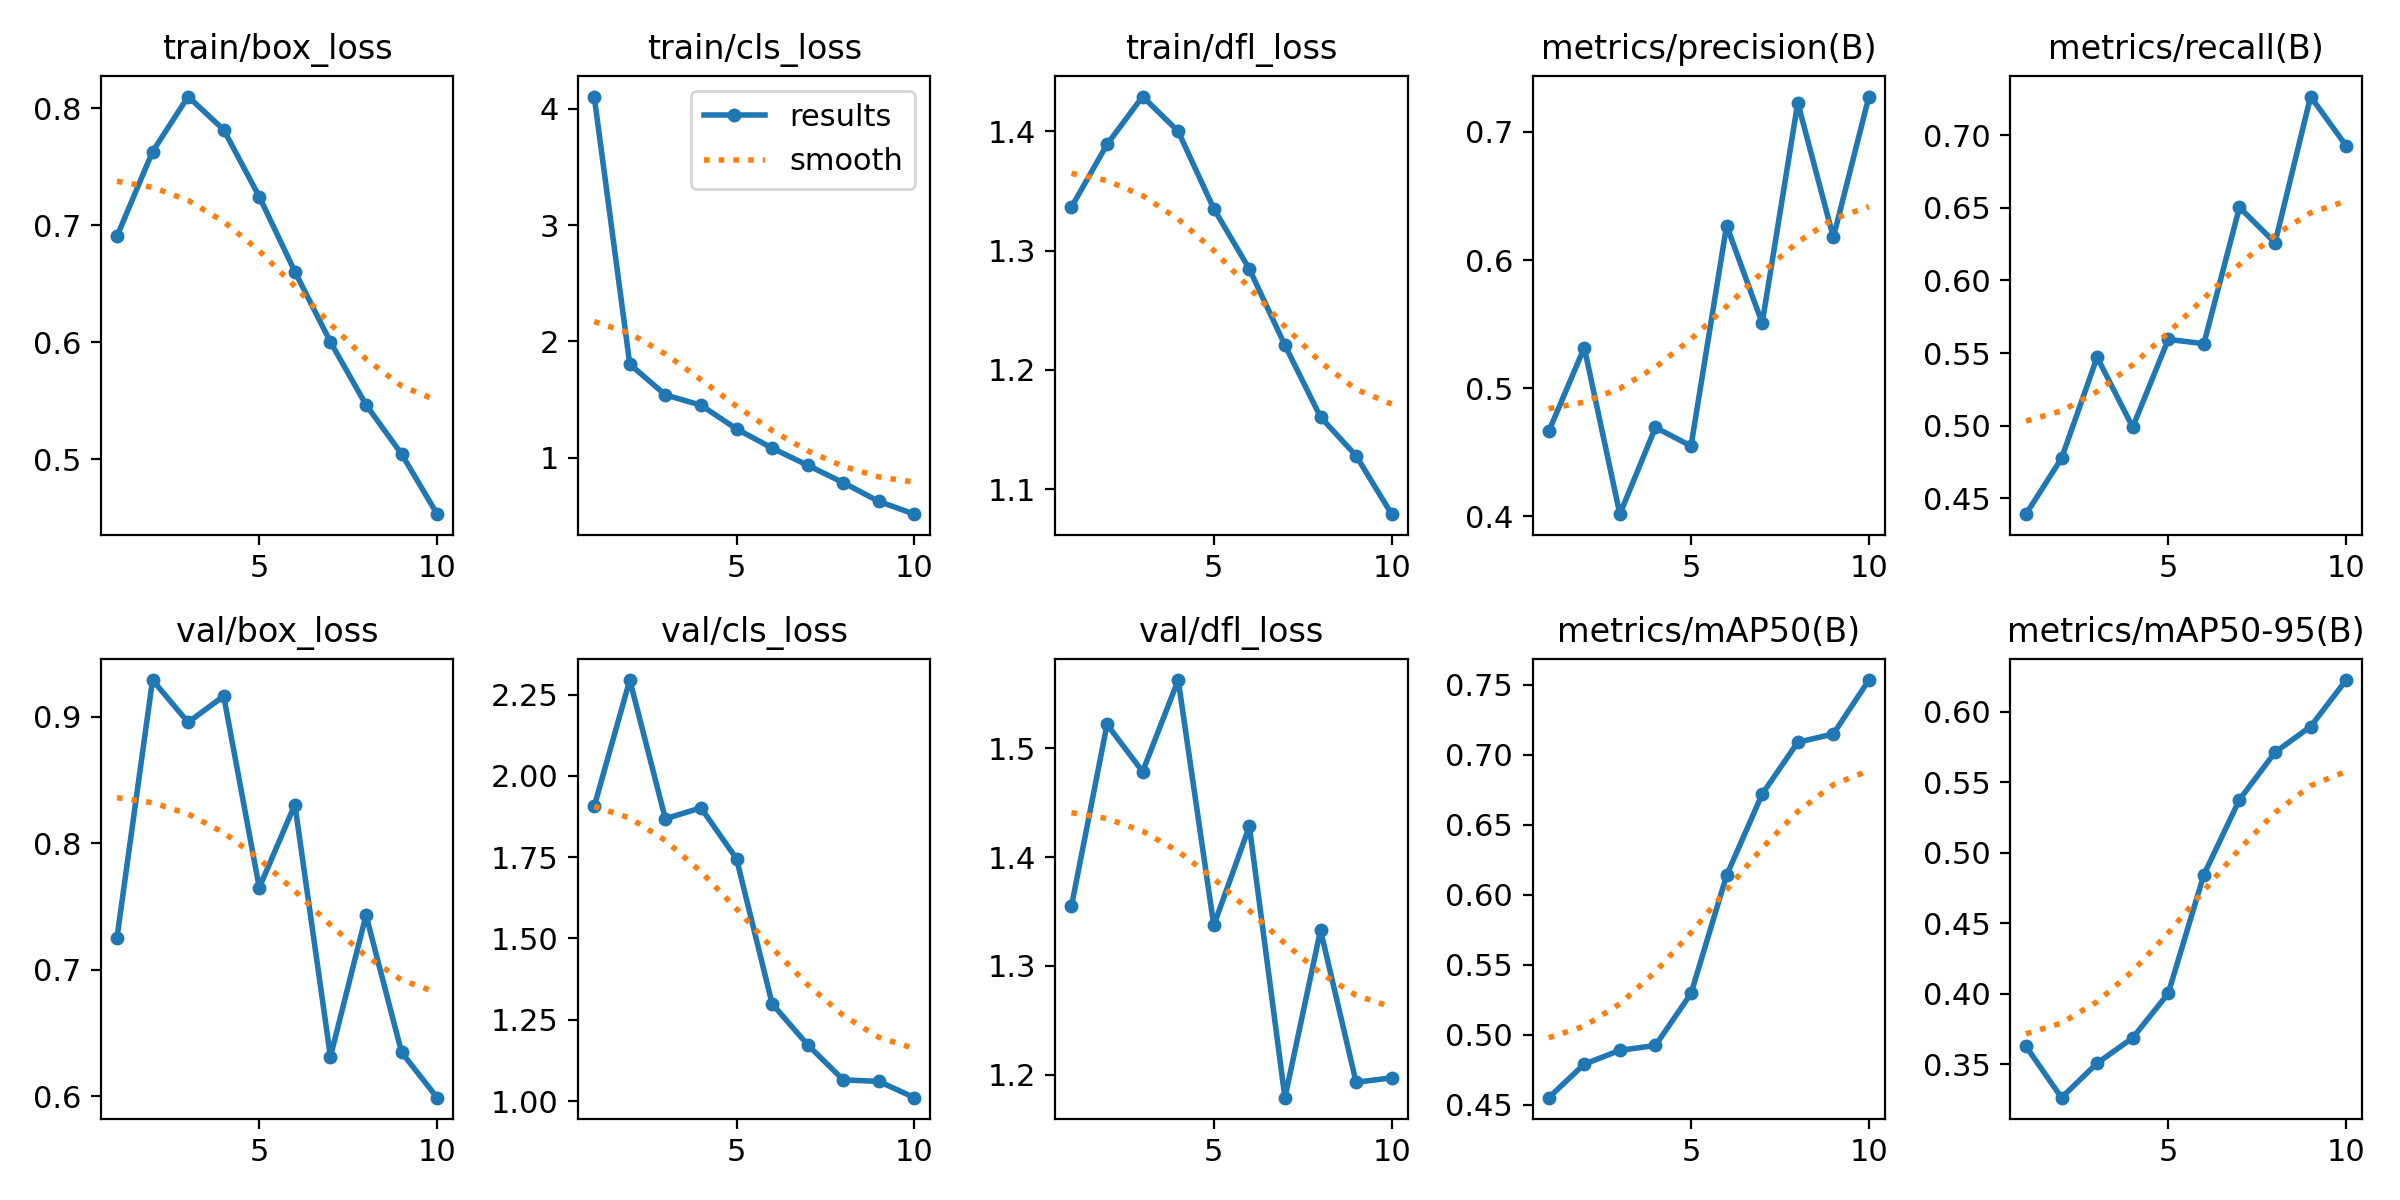

In [27]:
from IPython.display import Image as IPyImage

IPyImage(filename=f"{HOME}/runs/detect/train/results.png", width=600)

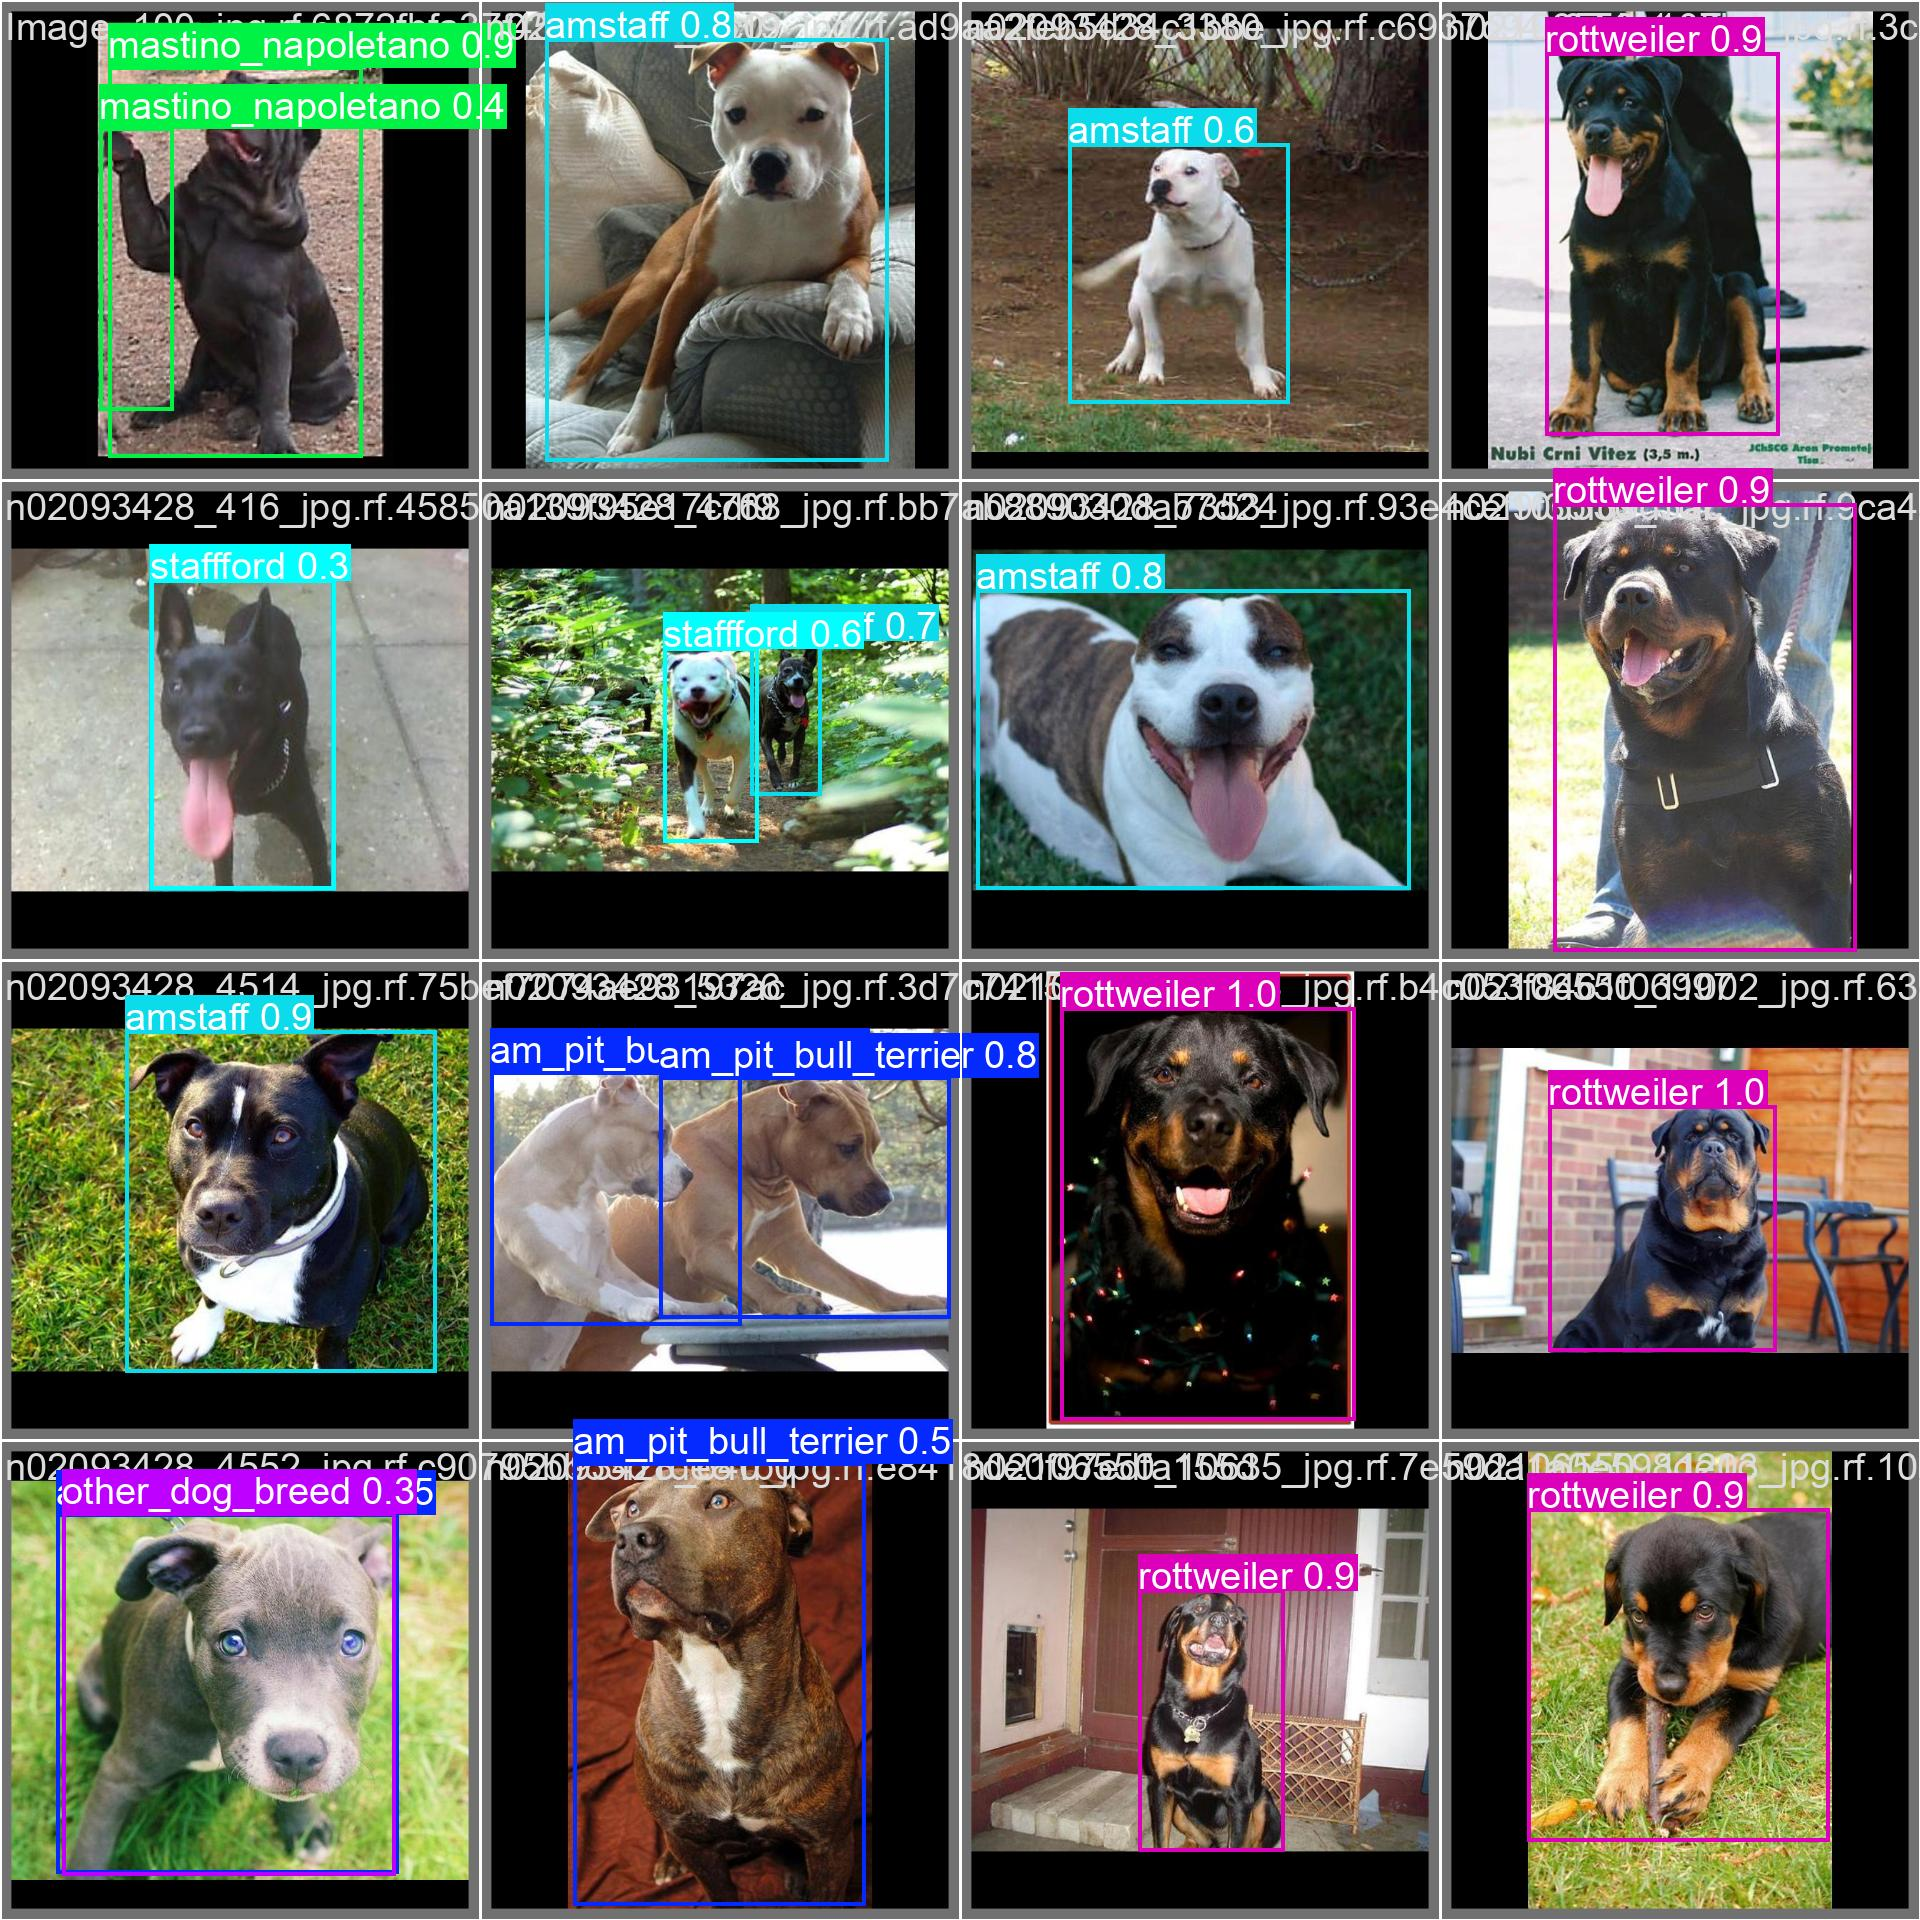

In [28]:
from IPython.display import Image as IPyImage

IPyImage(filename=f"{HOME}/runs/detect/train/val_batch0_pred.jpg", width=600)

## Validate fine-tuned model

In [29]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,417,831 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/helloListenDog_v1_dog_detection-1/valid/labels.cache... 162 images, 0 backgrounds, 0 corrupt: 100% 162/162 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 11/11 [00:04<00:00,  2.67it/s]
                   all        162        200      0.729      0.693      0.754      0.624
   am_pit_bull_terrier         17         22      0.676      0.665      0.738      0.652
               amstaff         27         29      0.615      0.497      0.547      0.468
           bullmastiff         22         25      0.762       0.76      0.825      0.678
           bullterrier          6          8      0.899          1      0.995      0.887
     dogue_de_bordeaux         12         13      0.923      0.919      0.934      0.896
                  

## Inference with custom model

In [30]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,417,831 parameters, 0 gradients, 21.3 GFLOPs

image 1/108 /content/datasets/helloListenDog_v1_dog_detection-1/test/images/Image_14_jpg.rf.f00648cbc8c092421dc20f539559308b.jpg: 640x640 1 dogue_de_bordeaux, 15.7ms
image 2/108 /content/datasets/helloListenDog_v1_dog_detection-1/test/images/Image_19_jpg.rf.33ea32f8d519e394e32fadd6e72fc724.jpg: 640x640 1 dogue_de_bordeaux, 1 person, 15.7ms
image 3/108 /content/datasets/helloListenDog_v1_dog_detection-1/test/images/Image_19_jpg.rf.e24788da71fd3c784d2d7c7862059f6f.jpg: 640x640 1 am_pit_bull_terrier, 15.6ms
image 4/108 /content/datasets/helloListenDog_v1_dog_detection-1/test/images/Image_24_jpg.rf.ed897cb36cbcaa010d94148d3506e33e.jpg: 640x640 1 mastino_napoletano, 15.6ms
image 5/108 /content/datasets/helloListenDog_v1_dog_detection-1/test/images/Image_25_jpg.rf.cfdf88253834b07563f9e1686523fdbe.jpg: 640x640 1 staffford, 15.6m

**NOTE:** Let's take a look at few results.

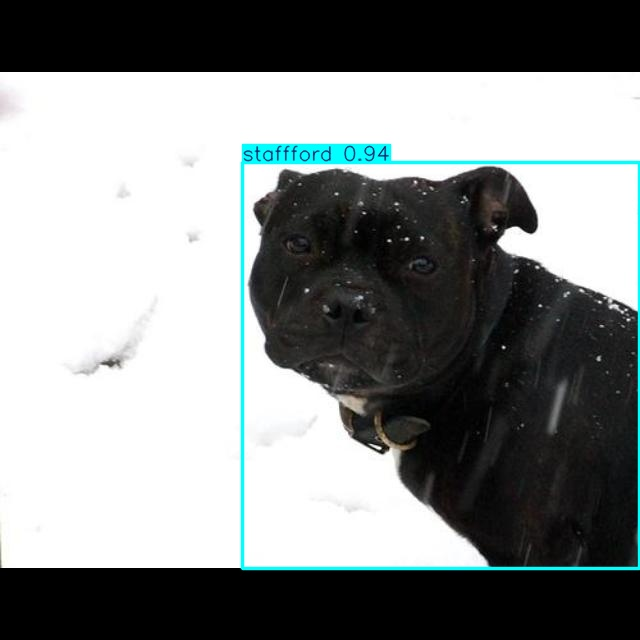

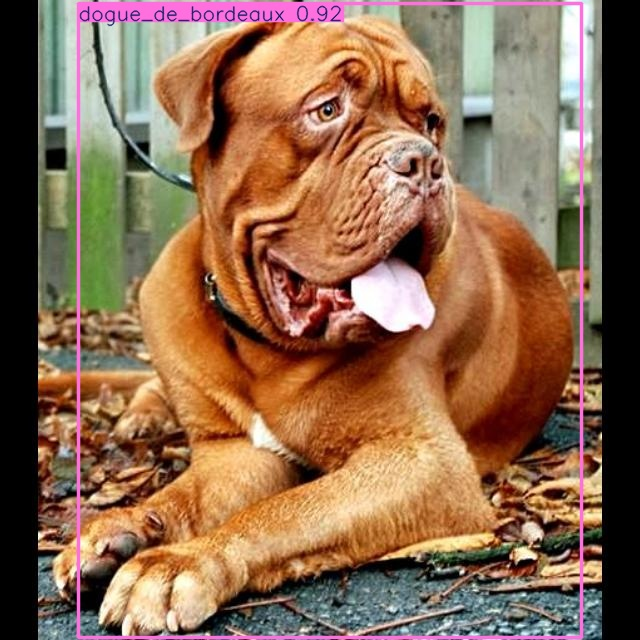

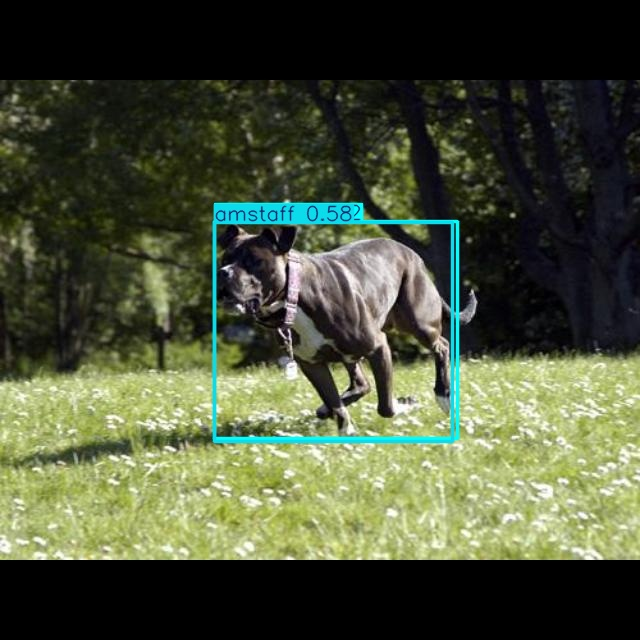

In [33]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f"{HOME}/runs/detect/predict*/"), key=os.path.getmtime)
for img in glob.glob(f"{latest_folder}/*.jpg")[10:13]:
    display(IPyImage(filename=img, width=600))
    print("\n")

## Deploy model on Roboflow

Once you have finished training your YOLOv11 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv11 weights.

In [34]:
project.version(dataset.version).deploy(
    model_type="yolov11", model_path=f"{HOME}/runs/detect/train/"
)

View the status of your deployment at: https://app.roboflow.com/mlzoomcamp2024/hellolistendog_v1_dog_detection/1
Share your model with the world at: https://universe.roboflow.com/mlzoomcamp2024/hellolistendog_v1_dog_detection/model/1


In [35]:
!pip install inference

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 9.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 907.5/907.5 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.9/891.9 kB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.7/774.7 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.8 MB/s e

Running inference on Image_38_jpg.rf.e28f78f731546d01b270c2d38e6d960b.jpg
Breed: bullterrier - 0.94


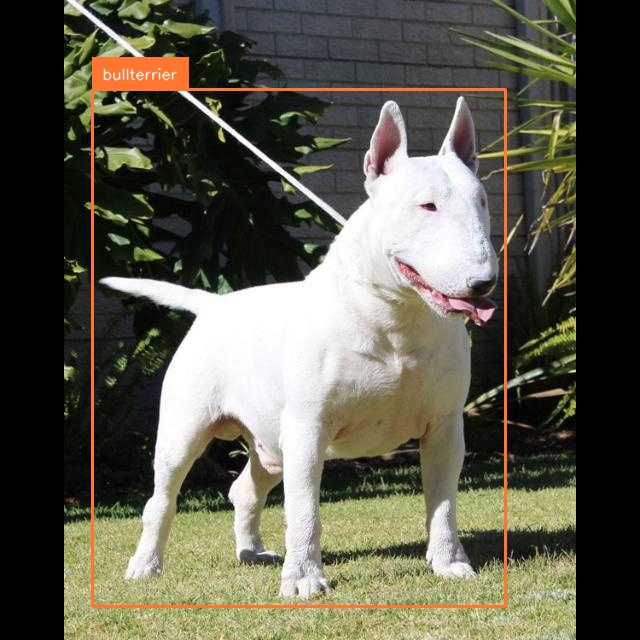

Running inference on n02093428_738_jpg.rf.fa93868291f035c5c2b0f4c03334eb97.jpg
Breed: staffford - 0.92


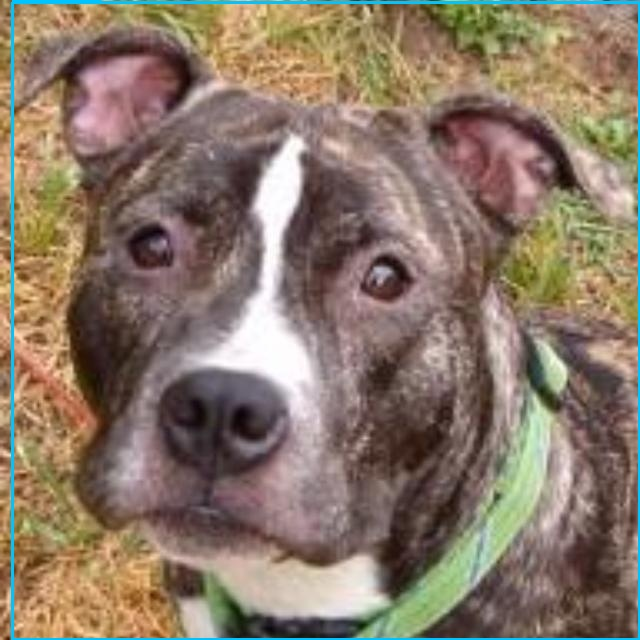

Running inference on n02093428_164_jpg.rf.5714c7d1d7efa3777940bf0d23c883e2.jpg
Breed: amstaff - 0.86


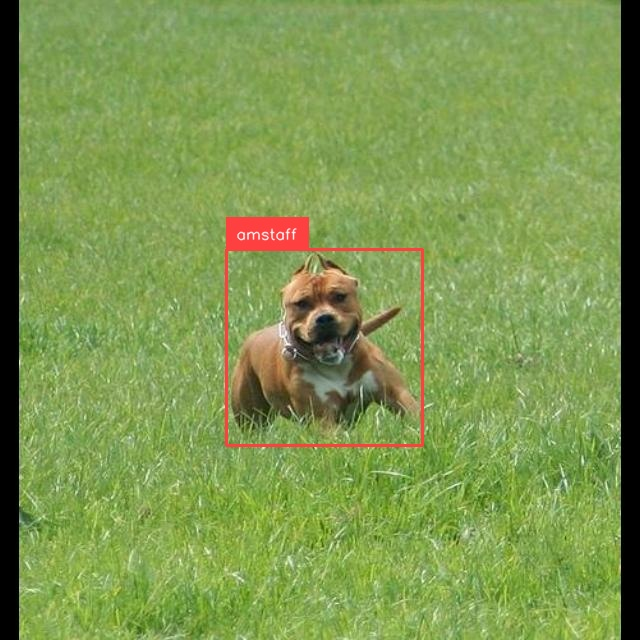

Running inference on n02106550_7608_jpg.rf.8f36ef51857e4a95a71597cd6775b65f.jpg
Breed: face - 0.79


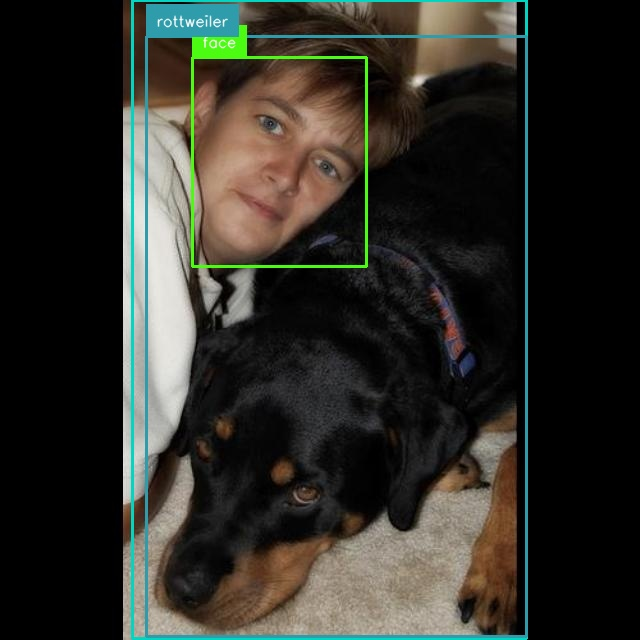

Running inference on n02106550_1567_jpg.rf.284f868c53b18f9a0a11766044a8c5f2.jpg
Breed: rottweiler - 0.90


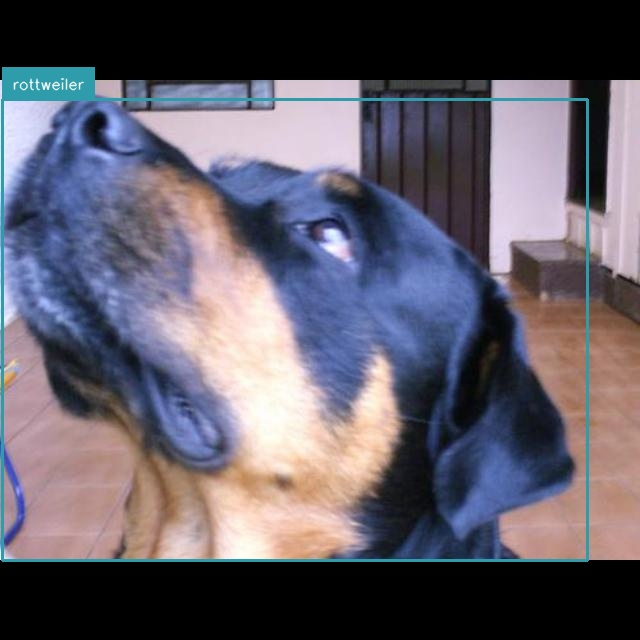

Running inference on n02093256_5600_jpg.rf.ff0cb707cb7e421f622af59269715982.jpg
Breed: staffford - 0.94


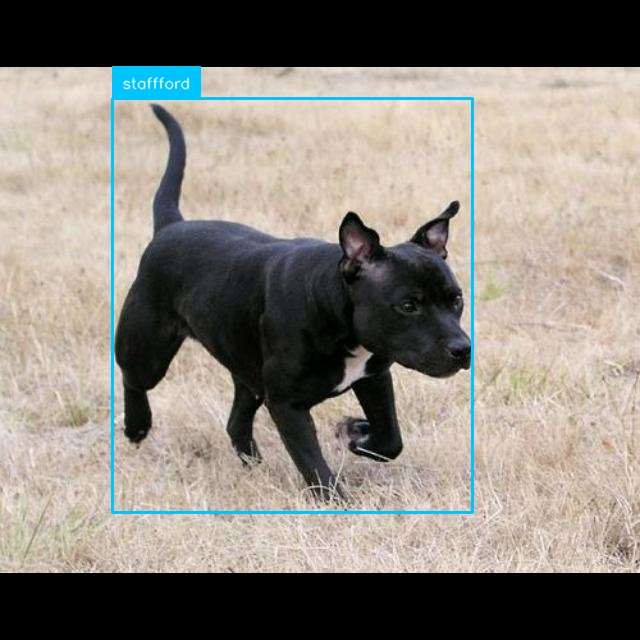

Running inference on n02093428_11_jpg.rf.9f070d5beb776ffc37f0eec874c6507c.jpg
Breed: amstaff - 0.71


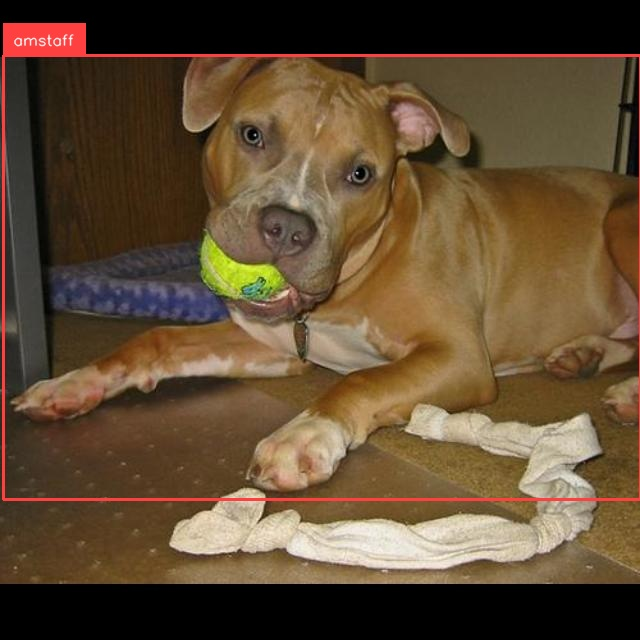

Running inference on n02106550_10966_jpg.rf.0f531a9b1f348081a245901c6523535d.jpg
Breed: rottweiler - 0.96


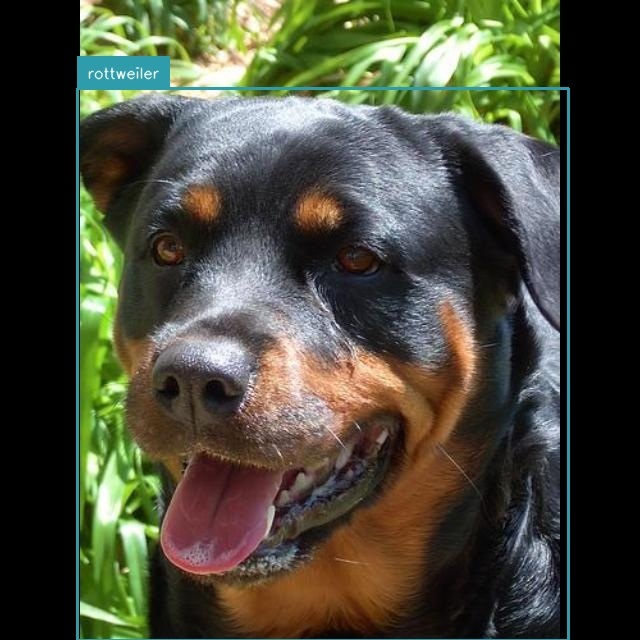

Running inference on n02108422_4520_jpg.rf.efc928fb2e9b80b52e4b703e75283e3e.jpg
Breed: bullmastiff - 0.90


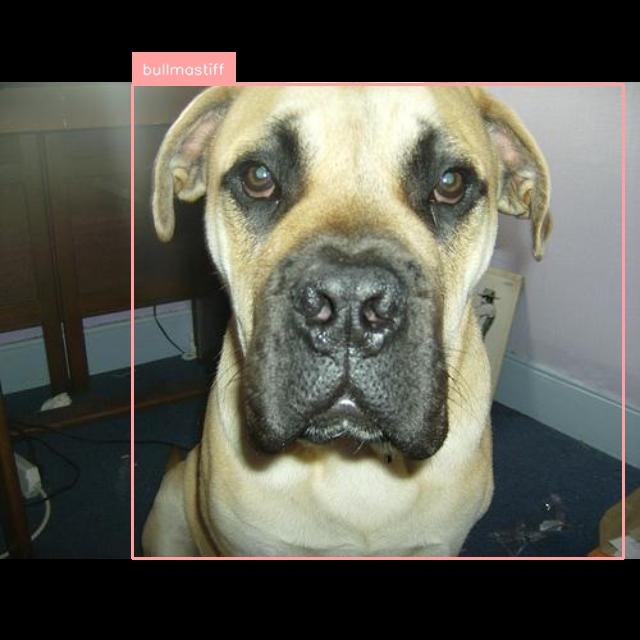

Running inference on n02106550_4910_jpg.rf.7b766e8bf672c4dde2ea2c66ff3e602b.jpg
Breed: rottweiler - 0.92


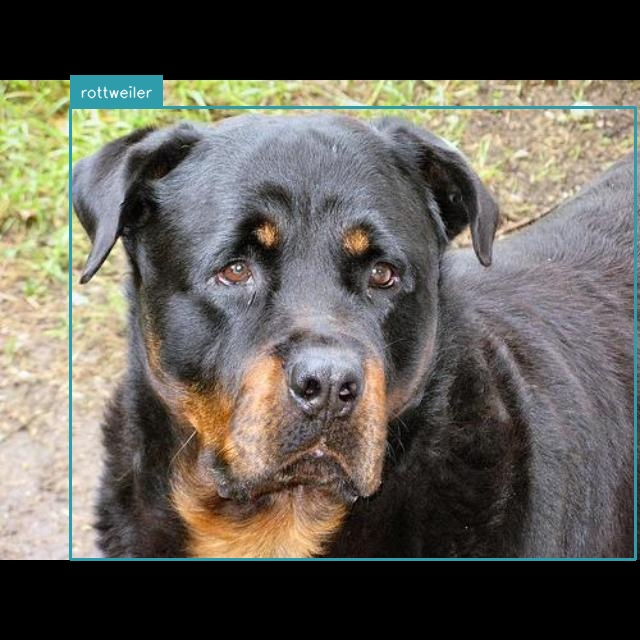

In [39]:
import os, random, cv2
import supervision as sv
import IPython
import inference

model_id = project.id.split("/")[1] + "/" + dataset.version
model = inference.get_model(model_id, userdata.get("ROBOFLOW_API_KEY"))

# Location of test set images
test_set_loc = dataset.location + "/test/images/"
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(10, len(test_images))):
    print("Running inference on " + img_name)

    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))

    # Perform inference
    results = model.infer(image, confidence=0.4, overlap=30)[0]
    for result in results.predictions[0]:
        #        print(type(result))
        #        print(result)
        if result[0] == "confidence":
            confidence = result[1]
        if result[0] == "class_name":
            class_name = result[1]

    # Now you have confidence and class_name
    formatted_confidence = "{:.2f}".format(confidence)
    print(f"Breed: {class_name} - {formatted_confidence}")

    detections = sv.Detections.from_inference(results)

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(
        scene=annotated_image, detections=detections
    )

    # Display annotated image
    _, ret = cv2.imencode(".jpg", annotated_image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)


## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.